Single-channel CSC With Weighted Lateral Inhibition / No Self Inhibition
========================================================================

This example demonstrates solving a convolutional sparse coding problem with a greyscale signal using a weighted grouping matrix

  $$\mathrm{argmin}_\mathbf{x} \; \frac{1}{2} \left\| \sum_m \mathbf{d}_m * \mathbf{x}_{m} - \mathbf{s} \right\|_2^2 + \lambda \sum_m \| \mathbf{x}_{m} \|_1 + \sum_m \mathbf{\omega}^T_m \| \mathbf{x}_m \| + \sum_m \mathbf{z}^T_m \|
  \mathbf{x}_m \| \;,$$

where $\mathbf{d}_{m}$ is the $m^{\text{th}}$ dictionary filter, $\mathbf{x}_{m}$ is the coefficient map corresponding to the $m^{\text{th}}$ dictionary filter, $\mathbf{s}$ is the input image, and $\mathbf{\omega}^T_m$ and $\mathbf{z}^T_m$
are inhibition weights corresponding to lateral and self inhibition, respectively (see [admm.cbpdnin.ConvBPDNInhib](http://sporco.rtfd.org/en/latest/modules/sporco.admm.cbpdnin.html#sporco.admm.cbpdnin.ConvBPDNInhib)).

In [1]:
from __future__ import print_function
from builtins import input
from builtins import range

import numpy as np

from sporco import util
from sporco import plot
plot.config_notebook_plotting()
import sporco.metric as sm
from sporco.admm import cbpdnin

Load example image.

In [2]:
img = util.ExampleImages().image('kodim23.png', scaled=True, gray=True,
                                 idxexp=np.s_[160:416, 60:316])

Highpass filter example image.

In [3]:
npd = 16
fltlmbd = 10
sl, sh = util.tikhonov_filter(img, fltlmbd, npd)

Load dictionary and display it.

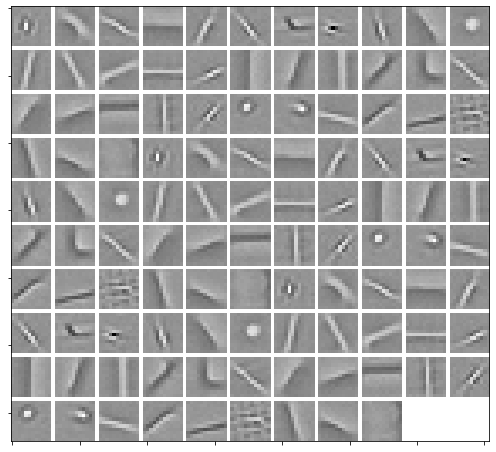

In [4]:
D = util.convdicts()['G:12x12x36']
# Repeat the dictionary three times, adding noise to each repetition
D = np.concatenate((D + 0.01 * np.random.randn(*D.shape),
                    D + 0.01 * np.random.randn(*D.shape),
                    D + 0.01 * np.random.randn(*D.shape)), axis=-1)
plot.imview(util.tiledict(D), fgsz=(9, 8))

Set [admm.cbpdnin.ConvBPDNInhib](http://sporco.rtfd.org/en/latest/modules/sporco.admm.cbpdnin.html#sporco.admm.cbpdnin.ConvBPDNInhib) solver options.

In [5]:
lmbda = 5e-2
mu = 5e-3  # if 'RegLat' diverges, lower mu
opt = cbpdnin.ConvBPDNInhib.Options({'Verbose': True, 'MaxMainIter': 200,
                                     'RelStopTol': 5e-3, 'AuxVarObj': False})

Initialise and run CSC solver.

In [6]:
# Create the Ng x M grouping matrix, where Ng is the number of groups,
# and M is the number of dictionary elements. A non-zero entry at
# Wg(n, m), means that element m belongs to group n. In this example,
# we create two grouping schemes where each scheme has a pairing. In
# the first scheme, elements i and i + 36 are paired, whereas in the
# second scheme, elements i and i + 72 are paired, for i = 0, ...,
# 35. The two different schemes are represented in a single grouping
# matrix, adjoined across the first dimension. All the weights in the
# first grouping scheme are 1, and all the weights in the second
# grouping scheme are 1/4. This means that the algorithm will
# prioritize inhibition within the first grouping scheme 4x more than
# that of the second.
Wg1 = np.concatenate((np.eye(36), np.eye(36), np.zeros((36, 36))), axis=-1)
Wg2 = 0.25 *\
    np.concatenate((np.eye(36), np.zeros((36, 36)), np.eye(36)), axis=-1)
Wg = np.append(Wg1, Wg2, axis=0)
# We additionally, choose a rectangular inhibition window of sample
# diameter 12.
b = cbpdnin.ConvBPDNInhib(D, sh, Wg, 12, ('boxcar'),
                          lmbda, mu, None, opt, dimK=0)
X = b.solve()
print("ConvBPDN solve time: %.2fs" % b.timer.elapsed('solve'))

Itn   Fnc       DFid      Regℓ1     RegLat    RegSelf   r         s         ρ       
------------------------------------------------------------------------------------


   0  7.70e+01  1.23e-01  1.54e+03  1.01e+01  0.00e+00  9.97e-01  1.98e-02  3.50e+00


   1  7.08e+01  7.66e-01  1.40e+03  1.73e+01  0.00e+00  9.36e-01  1.16e-01  3.50e+00


   2  6.31e+01  2.09e+00  1.22e+03  2.10e+01  0.00e+00  6.44e-01  2.96e-01  8.37e+00


   3  5.57e+01  3.30e+00  1.04e+03  2.84e+01  0.00e+00  3.18e-01  3.05e-01  1.04e+01


   4  5.69e+01  3.65e+00  1.06e+03  3.98e+01  0.00e+00  2.57e-01  2.09e-01  8.89e+00


   5  5.13e+01  3.83e+00  9.46e+02  4.20e+01  0.00e+00  2.15e-01  1.63e-01  8.89e+00


   6  4.58e+01  4.14e+00  8.29e+02  4.17e+01  0.00e+00  1.83e-01  1.31e-01  8.89e+00


   7  4.32e+01  4.44e+00  7.71e+02  4.32e+01  0.00e+00  1.52e-01  1.02e-01  8.89e+00


   8  4.12e+01  4.65e+00  7.26e+02  4.61e+01  0.00e+00  1.22e-01  8.73e-02  8.89e+00


   9  3.96e+01  4.75e+00  6.92e+02  4.89e+01  0.00e+00  1.00e-01  7.86e-02  8.89e+00


  10  3.86e+01  4.78e+00  6.72e+02  5.09e+01  0.00e+00  8.59e-02  6.82e-02  8.89e+00


  11  3.73e+01  4.81e+00  6.45e+02  5.19e+01  0.00e+00  7.49e-02  5.81e-02  8.89e+00


  12  3.56e+01  4.86e+00  6.09e+02  5.22e+01  0.00e+00  6.52e-02  5.28e-02  8.89e+00


  13  3.42e+01  4.93e+00  5.80e+02  5.26e+01  0.00e+00  5.68e-02  4.86e-02  8.89e+00


  14  3.36e+01  4.99e+00  5.66e+02  5.35e+01  0.00e+00  5.31e-02  4.28e-02  8.07e+00


  15  3.32e+01  5.03e+00  5.58e+02  5.45e+01  0.00e+00  4.72e-02  3.71e-02  8.07e+00


  16  3.26e+01  5.06e+00  5.46e+02  5.51e+01  0.00e+00  4.20e-02  3.40e-02  8.07e+00


  17  3.20e+01  5.07e+00  5.32e+02  5.52e+01  0.00e+00  3.75e-02  3.17e-02  8.07e+00


  18  3.14e+01  5.09e+00  5.21e+02  5.53e+01  0.00e+00  3.38e-02  2.91e-02  8.07e+00


  19  3.09e+01  5.10e+00  5.11e+02  5.53e+01  0.00e+00  3.23e-02  2.70e-02  7.31e+00


  20  3.06e+01  5.11e+00  5.04e+02  5.53e+01  0.00e+00  2.96e-02  2.49e-02  7.31e+00


  21  3.03e+01  5.12e+00  4.99e+02  5.53e+01  0.00e+00  2.72e-02  2.28e-02  7.31e+00


  22  3.00e+01  5.13e+00  4.92e+02  5.52e+01  0.00e+00  2.50e-02  2.12e-02  7.31e+00


  23  2.96e+01  5.14e+00  4.85e+02  5.50e+01  0.00e+00  2.30e-02  2.01e-02  7.31e+00


  24  2.94e+01  5.15e+00  4.79e+02  5.48e+01  0.00e+00  2.25e-02  1.91e-02  6.57e+00


  25  2.93e+01  5.15e+00  4.77e+02  5.46e+01  0.00e+00  2.23e-02  1.78e-02  5.99e+00


  26  2.92e+01  5.15e+00  4.75e+02  5.43e+01  0.00e+00  2.09e-02  1.65e-02  5.99e+00


  27  2.90e+01  5.15e+00  4.71e+02  5.40e+01  0.00e+00  1.95e-02  1.56e-02  5.99e+00


  28  2.87e+01  5.14e+00  4.66e+02  5.36e+01  0.00e+00  1.83e-02  1.50e-02  5.99e+00


  29  2.85e+01  5.15e+00  4.62e+02  5.31e+01  0.00e+00  1.72e-02  1.42e-02  5.99e+00


  30  2.83e+01  5.15e+00  4.58e+02  5.26e+01  0.00e+00  1.62e-02  1.34e-02  5.99e+00


  31  2.81e+01  5.16e+00  4.53e+02  5.21e+01  0.00e+00  1.53e-02  1.29e-02  5.99e+00


  32  2.79e+01  5.16e+00  4.49e+02  5.16e+01  0.00e+00  1.44e-02  1.25e-02  5.99e+00


  33  2.78e+01  5.16e+00  4.47e+02  5.11e+01  0.00e+00  1.45e-02  1.20e-02  5.39e+00


  34  2.77e+01  5.16e+00  4.46e+02  5.07e+01  0.00e+00  1.38e-02  1.14e-02  5.39e+00


  35  2.77e+01  5.16e+00  4.45e+02  5.02e+01  0.00e+00  1.32e-02  1.09e-02  5.39e+00


  36  2.76e+01  5.16e+00  4.44e+02  4.98e+01  0.00e+00  1.26e-02  1.05e-02  5.39e+00


  37  2.75e+01  5.16e+00  4.42e+02  4.94e+01  0.00e+00  1.20e-02  1.02e-02  5.39e+00


  38  2.74e+01  5.16e+00  4.40e+02  4.89e+01  0.00e+00  1.15e-02  9.82e-03  5.39e+00


  39  2.73e+01  5.15e+00  4.37e+02  4.84e+01  0.00e+00  1.17e-02  9.48e-03  4.90e+00


  40  2.72e+01  5.15e+00  4.36e+02  4.80e+01  0.00e+00  1.12e-02  9.15e-03  4.90e+00


  41  2.71e+01  5.15e+00  4.34e+02  4.75e+01  0.00e+00  1.07e-02  8.85e-03  4.90e+00


  42  2.70e+01  5.15e+00  4.33e+02  4.71e+01  0.00e+00  1.03e-02  8.54e-03  4.90e+00


  43  2.70e+01  5.15e+00  4.31e+02  4.67e+01  0.00e+00  9.93e-03  8.26e-03  4.90e+00


  44  2.69e+01  5.15e+00  4.30e+02  4.63e+01  0.00e+00  9.55e-03  8.02e-03  4.90e+00


  45  2.68e+01  5.15e+00  4.29e+02  4.60e+01  0.00e+00  9.20e-03  7.82e-03  4.90e+00


  46  2.68e+01  5.15e+00  4.28e+02  4.56e+01  0.00e+00  9.44e-03  7.63e-03  4.46e+00


  47  2.67e+01  5.15e+00  4.27e+02  4.53e+01  0.00e+00  9.14e-03  7.42e-03  4.46e+00


  48  2.67e+01  5.15e+00  4.26e+02  4.49e+01  0.00e+00  8.84e-03  7.19e-03  4.46e+00


  49  2.67e+01  5.15e+00  4.26e+02  4.46e+01  0.00e+00  8.56e-03  6.99e-03  4.46e+00


  50  2.66e+01  5.15e+00  4.25e+02  4.43e+01  0.00e+00  8.30e-03  6.80e-03  4.46e+00


  51  2.66e+01  5.15e+00  4.24e+02  4.40e+01  0.00e+00  8.01e-03  6.63e-03  4.46e+00


  52  2.65e+01  5.15e+00  4.23e+02  4.37e+01  0.00e+00  7.76e-03  6.45e-03  4.46e+00


  53  2.64e+01  5.15e+00  4.21e+02  4.34e+01  0.00e+00  7.52e-03  6.29e-03  4.46e+00


  54  2.64e+01  5.15e+00  4.20e+02  4.31e+01  0.00e+00  7.29e-03  6.14e-03  4.46e+00


  55  2.63e+01  5.15e+00  4.19e+02  4.28e+01  0.00e+00  7.07e-03  6.01e-03  4.46e+00


  56  2.63e+01  5.15e+00  4.18e+02  4.26e+01  0.00e+00  7.32e-03  5.88e-03  4.06e+00


  57  2.62e+01  5.15e+00  4.17e+02  4.23e+01  0.00e+00  7.12e-03  5.75e-03  4.06e+00


  58  2.62e+01  5.15e+00  4.17e+02  4.20e+01  0.00e+00  6.95e-03  5.62e-03  4.06e+00


  59  2.62e+01  5.15e+00  4.16e+02  4.18e+01  0.00e+00  6.77e-03  5.49e-03  4.06e+00


  60  2.62e+01  5.15e+00  4.16e+02  4.16e+01  0.00e+00  6.60e-03  5.36e-03  4.06e+00


  61  2.61e+01  5.15e+00  4.16e+02  4.14e+01  0.00e+00  6.43e-03  5.25e-03  4.06e+00


  62  2.61e+01  5.15e+00  4.15e+02  4.12e+01  0.00e+00  6.26e-03  5.14e-03  4.06e+00


  63  2.61e+01  5.15e+00  4.15e+02  4.10e+01  0.00e+00  6.09e-03  5.02e-03  4.06e+00


  64  2.61e+01  5.15e+00  4.14e+02  4.08e+01  0.00e+00  5.93e-03  4.92e-03  4.06e+00


  65  2.60e+01  5.15e+00  4.14e+02  4.06e+01  0.00e+00  5.78e-03  4.82e-03  4.06e+00


  66  2.60e+01  5.15e+00  4.13e+02  4.05e+01  0.00e+00  5.63e-03  4.73e-03  4.06e+00


  67  2.60e+01  5.15e+00  4.12e+02  4.03e+01  0.00e+00  5.49e-03  4.63e-03  4.06e+00


  68  2.59e+01  5.15e+00  4.12e+02  4.01e+01  0.00e+00  5.35e-03  4.55e-03  4.06e+00


  69  2.59e+01  5.15e+00  4.11e+02  4.00e+01  0.00e+00  5.59e-03  4.45e-03  3.70e+00


  70  2.59e+01  5.15e+00  4.11e+02  3.98e+01  0.00e+00  5.47e-03  4.36e-03  3.70e+00


  71  2.59e+01  5.15e+00  4.11e+02  3.97e+01  0.00e+00  5.36e-03  4.27e-03  3.70e+00


  72  2.59e+01  5.15e+00  4.11e+02  3.95e+01  0.00e+00  5.25e-03  4.19e-03  3.70e+00


  73  2.59e+01  5.15e+00  4.10e+02  3.94e+01  0.00e+00  5.13e-03  4.11e-03  3.70e+00


  74  2.58e+01  5.15e+00  4.10e+02  3.93e+01  0.00e+00  5.02e-03  4.03e-03  3.70e+00


  75  2.58e+01  5.15e+00  4.10e+02  3.92e+01  0.00e+00  4.92e-03  3.96e-03  3.70e+00
------------------------------------------------------------------------------------
ConvBPDN solve time: 79.05s


Reconstruct image from sparse representation.

In [7]:
shr = b.reconstruct().squeeze()
imgr = sl + shr
print("Reconstruction PSNR: %.2fdB\n" % sm.psnr(img, imgr))

Reconstruction PSNR: 37.49dB



Display low pass component and sum of absolute values of coefficient maps of highpass component.

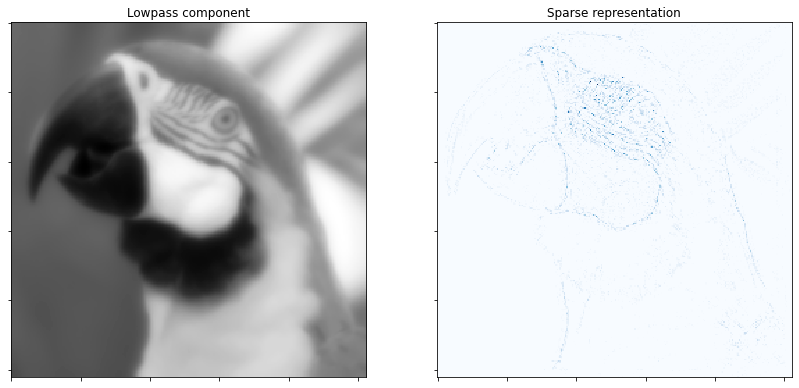

In [8]:
fig = plot.figure(figsize=(14, 7))
plot.subplot(1, 2, 1)
plot.imview(sl, title='Lowpass component', fig=fig)
plot.subplot(1, 2, 2)
plot.imview(np.sum(abs(X), axis=b.cri.axisM).squeeze(), cmap=plot.cm.Blues,
            title='Sparse representation', fig=fig)
fig.show()

Show activation of grouped elements column-wise for first four groups of both schemes.  As mu is lowered, the vertical pairs should look more and more similar.  You will likely need to zoom in to see the activations clearly.  In general, you should observe that the second-scheme pairs should have more similar-looking activations than first-scheme pairs, proportional to mu of course.

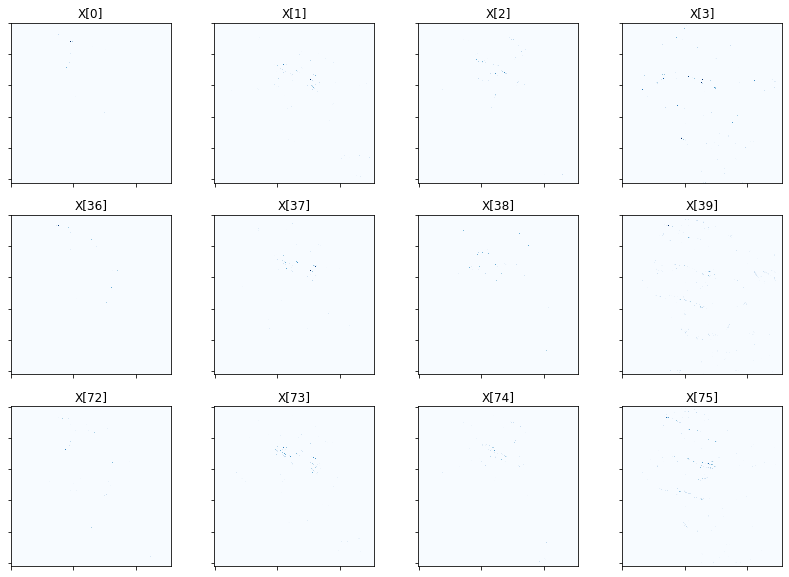

In [9]:
fig = plot.figure(figsize=(14, 10))
for i in range(4):
    plot.subplot(3, 4, i + 1)
    plot.imview(abs(X[:, :, :, :, i]).squeeze(), cmap=plot.cm.Blues,
                title=f'X[{i}]', fig=fig)
    plot.subplot(3, 4, i + 5)
    plot.imview(abs(X[:, :, :, :, i + 36]).squeeze(), cmap=plot.cm.Blues,
                title=f'X[{i+36}]', fig=fig)
    plot.subplot(3, 4, i + 9)
    plot.imview(abs(X[:, :, :, :, i + 72]).squeeze(), cmap=plot.cm.Blues,
                title=f'X[{i+72}]', fig=fig)
fig.show()

Display original and reconstructed images.

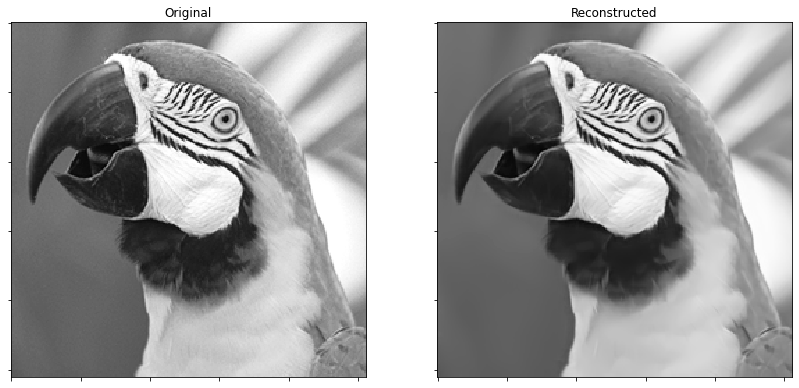

In [10]:
fig = plot.figure(figsize=(14, 7))
plot.subplot(1, 2, 1)
plot.imview(img, title='Original', fig=fig)
plot.subplot(1, 2, 2)
plot.imview(imgr, title='Reconstructed', fig=fig)
fig.show()

Get iterations statistics from solver object and plot functional value, ADMM primary and dual residuals, and automatically adjusted ADMM penalty parameter against the iteration number.

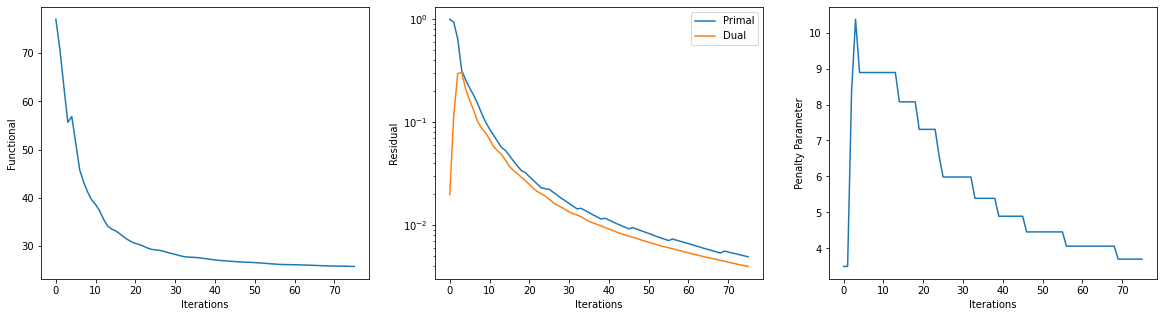

In [11]:
its = b.getitstat()
fig = plot.figure(figsize=(20, 5))
plot.subplot(1, 3, 1)
plot.plot(its.ObjFun, xlbl='Iterations', ylbl='Functional', fig=fig)
plot.subplot(1, 3, 2)
plot.plot(np.vstack((its.PrimalRsdl, its.DualRsdl)).T,
          ptyp='semilogy', xlbl='Iterations', ylbl='Residual',
          lgnd=['Primal', 'Dual'], fig=fig)
plot.subplot(1, 3, 3)
plot.plot(its.Rho, xlbl='Iterations', ylbl='Penalty Parameter', fig=fig)
fig.show()